In [1]:
import numpy as np
import pandas as pd
import json
import os
import shutil
import subprocess as sp
import pyautogui as pg
import timeit
import time
from matplotlib import pyplot as plt
# from model import Model, read_from_doc, write_to_doc
import h5py
import sys
from scipy.optimize import curve_fit
from ipywidgets import interact
import ipywidgets as widgets

In [3]:
def adjusted_weibull(x,a,b,c):
    return (b/a) * (x/b)**(b-1) * np.exp(-(x/a)**b) + c
def scaled_exp(x,a,b,c):
    return a*np.exp(-b*x) + c
def regan_weibull(x,a,b,c):
    return np.exp(-(x/a)**b) + c

### Fire

In [2]:
from scipy.special import gamma
from scipy.stats import weibull_min

In [3]:
def weibull_int(b,c):
    x = np.arange(0,120,0.5)
    # wei = (c/b) * (x/c)**(c-1) * np.exp(-(x/b)**c)
    # plt.scatter(x, wei)
    # plt.plot(x,wei)
    # mean = b * gamma(1+1/c)
    # plt.axvline(mean, ls='--')
    wei = weibull_min(c, scale=b, loc=0)
    plt.plot(x,wei.pdf(x), c='orange')
    plt.axvline(wei.mean(), ls='--', c='orange')
    # plt.plot(x,wei.cdf(x), c='red')
    # plt.plot(x, 1-wei.cdf(x), c='red')
    # wei_samples = wei.rvs(1000)
    # wei_samples = weibull_min.rvs(c, scale=b, loc=0, size=1000)
    # wei_samples = np.random.weibull(c, 1000)*b
    # plt.hist(wei_samples, density=True, color='orange', alpha=0.5, bins=30)
    hazard = (c * np.power(x, c-1)) / b**c
    plt.plot(hazard, c='red')
    plt.xlim(-5, 120)
interact(weibull_int, 
         b=widgets.FloatSlider(value=44, min=0.5, max=130, step=0.5), #scale
         c=widgets.FloatSlider(value=1.42, min=0.01, max=10, step=0.01)) #shape

interactive(children=(FloatSlider(value=44.0, description='b', max=130.0, min=0.5, step=0.5), FloatSlider(valu…

<function __main__.weibull_int(b, c)>

#### Approx fraction extirpated

In [395]:
# Using cdf
x = np.arange(0,120,1)
wei = weibull_min(1.42, scale=44, loc=0)
num_iter = 100
num_extirpated = 0
min_age = 20
for i in range(num_iter):
    t_star = 0
    for t in x:
        fire = np.random.binomial(1,wei.cdf(t_star))
        # print(t_star, wei.cdf(t_star), fire)
        if fire:
            if t_star < min_age:
                num_extirpated += 1
                break
            t_star = 0
        t_star += 1
num_extirpated/num_iter

1.0

In [407]:
# Using hazard
x = np.arange(0,120,1)
c = 1.42; b = 44
hazard = (c * np.power(x, c-1)) / b**c
num_iter = 10000
num_extirpated = 0
min_age = 20
for i in range(num_iter):
    t_star = 0
    for x_i in range(len(x)):
        fire = np.random.binomial(1, hazard[t_star])
        # print(t_star, hazard[t_star], fire)
        if fire:
            if t_star < min_age:
                num_extirpated += 1
                break
            t_star = 0
        t_star += 1
num_extirpated/num_iter

0.5685

In [394]:
num_iter = 10000
num_extirpated = 0
wei = weibull_min(1.42, scale=44)
min_age = 20
for i in range(num_iter):
    yr_final = 0
    while yr_final < 120:
        interval = wei.rvs(1)[0]
        yr_final += interval
        if interval < min_age:
            num_extirpated += 1
            break
    # print(yr_final)
num_extirpated/num_iter

0.6057

#### Estimate fri

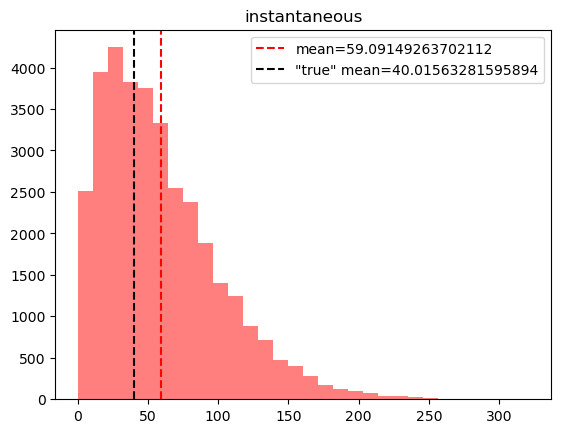

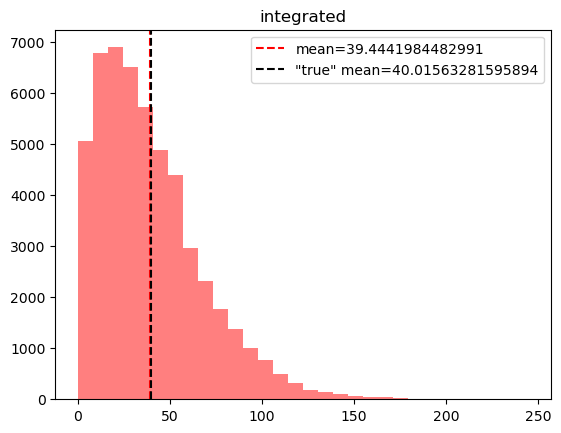

In [14]:
# Using hazard
delta_t = 0.25
t_final = 520
t = np.arange(delta_t,t_final,delta_t)
c = 1.42
b = 44
b_eff = b*delta_t
t_hazard = np.append(t, t_final)
hazard = (c * np.power(t_hazard, c-1)) / b**c
frequency_vec = (1/b_eff**c) * ((t + delta_t)**c - t**c)
true_mean = b * gamma(1+1/c)
num_iter = 1000
keys = ['instantaneous', 'integrated']
for key in keys:
    fire_vec = np.zeros((num_iter, len(t)))
    for i in range(num_iter):
        t_star = 0
        for t_i in range(len(t)):
            if key == 'instantaneous':
                fire = np.random.binomial(1, hazard[t_star])
            elif key == 'integrated':
                frequency = frequency_vec[t_star]
                fire = np.random.poisson(lam=frequency, size=1)
            if fire:
                fire_vec[i, t_i] = 1
                t_star = 0
            else:
                t_star += 1
    fri_vec = []
    for sim in fire_vec:
        fire_yrs = np.nonzero(sim)[0]
        if len(fire_yrs) != 0:
            fri_vec.append(fire_yrs[0])
            if len(fire_yrs) > 1:
                for i in range(len(fire_yrs)-1):
                    fri_vec.append(fire_yrs[i+1]-fire_yrs[i])
    mean = np.mean(fri_vec)
    hist = plt.hist(fri_vec, bins=30, color='red', alpha=0.5);
    plt.axvline(mean, ls='--', color='red', label='mean={}'.format(mean))
    plt.axvline(true_mean, ls='--', color='k', label='"true" mean={}'.format(true_mean))
    plt.title(key)
    plt.legend()
    plt.show()

#### Avg num births

In [4]:
# Read in map parameters
params = {}
for pr in ['mortality', 'fecundity']:
    with open('model_fitting/{}/map.json'.format(pr), 'r') as handle:
        params.update(json.load(handle)) 

In [253]:
delta_t = 1
t_final = 100
t_vec = np.arange(delta_t, t_final, delta_t)
rho_a = params['rho_max'] / (1+np.exp(-params['eta_rho']*(t_vec-params['a_mature'])))
sigm_a = params['sigm_max'] / (1+np.exp(-params['eta_sigm']*(t_vec-params['a_mature'])))
epsilon_rho = np.exp(sigm_a**2 / 2)
fecundities = rho_a*epsilon_rho
c = 1.42
b = 44
b_eff = b*delta_t
wei = weibull_min(c, scale=b_eff, loc=0)
expected_num_births = np.trapz(fecundities*wei.pdf(t_vec))

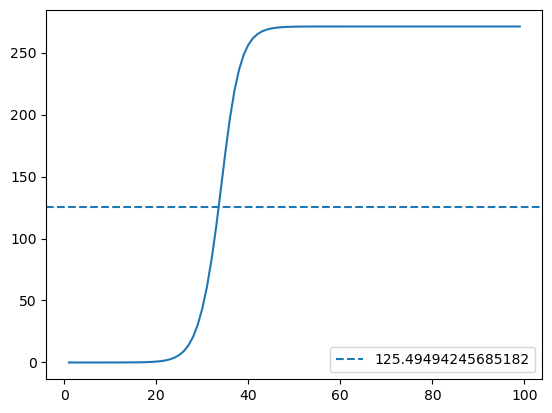

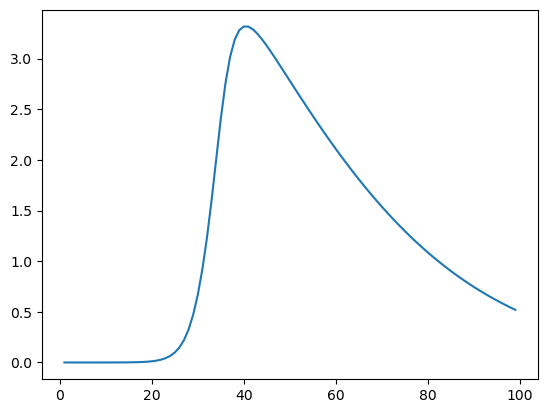

In [254]:
plt.plot(t_vec, fecundities)
plt.axhline(expected_num_births, ls='--', label=str(expected_num_births))
plt.legend()
plt.show()
plt.plot(t_vec, fecundities*wei.pdf(t_vec))

In [258]:
fri = b * gamma(1+1/c)
(fri**c - delta_t**c) / b**c

0.8692656157596313

In [276]:
repro_min = 0.005*params['rho_max']*np.exp(params['sigm_max']**2/2)
rho_ints = [np.trapz(fecundities[:i]) for i in range(len(t_vec))]
diffs = [abs(repro_min - rho_int) for rho_int in rho_ints]
min_i = min(range(len(diffs)), key=diffs.__getitem__)
q = t_vec[min_i]
avg_num_extir_fires = (q**c - delta_t**c) / b**c
avg_num_extir_fires

0.32176960574851204

### Fecundity

Hows about fecundity

/var/folders/jd/fczwycqx1lxch_x4svbjh6680000gn/T/ipykernel_43120/1603251345.py:10: RuntimeWarning: invalid value encountered in scalar divide
  fecundity_err = fecundity_bren[i] * np.sqrt((prefire_density_se[i]/prefire_density[i])**2 + (rec_density_se[i]/rec_density[i])**2)


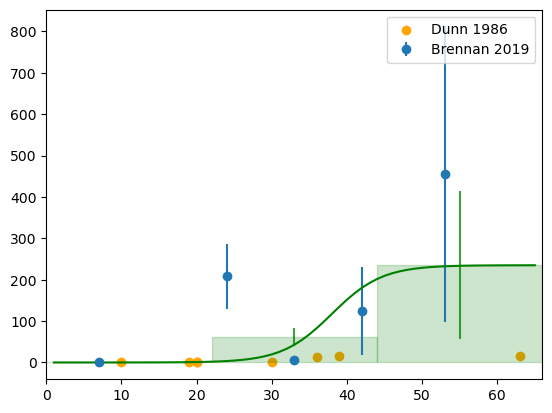

In [2]:
# Brennan 2019
stand_age_bren = np.array([7,24,33,42,53])
prefire_density = np.array([2205,48,3430,233,400])
prefire_density_se = np.array([35,14,308,136,240])
rec_density = np.array([0,10000,18500,29000,182000])
rec_density_se = np.array([0,2345,9385,18443,92000])3
fecundity_bren = rec_density / prefire_density
fecundity_err_bren = np.zeros(len(fecundity_bren))
for i in range(len(fecundity_err_bren)):
    fecundity_err = fecundity_bren[i] * np.sqrt((prefire_density_se[i]/prefire_density[i])**2 + (rec_density_se[i]/rec_density[i])**2)
    if np.isnan(fecundity_err):
        fecundity_err = 0
    fecundity_err_bren[i] = fecundity_err
plt.errorbar(stand_age_bren, fecundity_bren, yerr=fecundity_err_bren, fmt='o', label='Brennan 2019')

# Dunn 1986
stand_age_dunn = np.array([10,19,20,20,30,36,39,63])
fecundity_dunn = (np.array([0,0.1,2.9,26.5,15.7,1206.5,1387.3,1400]) / 100) + 1
# Assume something ad hoc for CV on Dunn's measurements
fecundity_err_dunn = np.repeat(0.75, len(fecundity_dunn)) * fecundity_dunn
plt.scatter(stand_age_dunn, fecundity_dunn, color='orange', label='Dunn 1986')

stand_age_all = np.concatenate((stand_age_bren, stand_age_dunn))
sort = np.argsort(stand_age_all)
stand_age_all = stand_age_all[sort]
fecundity_all = np.concatenate((fecundity_bren, fecundity_dunn))[sort]
fecundity_err_all = np.concatenate((fecundity_err_bren,fecundity_err_dunn))[sort]
binwidth = 22
numbins = max(stand_age_all) // binwidth + (max(stand_age_all) % binwidth > 0)
age_cntrs = np.zeros(numbins)
mean_fecundities = []
bin_errors = []
for i in range(numbins):
    filt = ((stand_age_all > binwidth*i) & (stand_age_all <= binwidth*(i+1)))
    sub = fecundity_all[filt]
    mean_fecundities.append(sub.mean())
    age_cntr = binwidth*i + binwidth/2
    age_cntrs[i] = age_cntr
    plt.fill_between([binwidth*i, binwidth*(i+1)], 0, sub.mean(), color='green', alpha=0.2)
    err = (1/sum(filt))*np.sqrt(sum(fecundity_err_all[filt]**2))
    bin_errors.append(err)
    plt.errorbar(age_cntr, sub.mean(), yerr=err, c='g', alpha=0.75)
plt.xlim(0,age_cntr+binwidth/2)

a_vec = np.arange(1,int(age_cntr+binwidth/2))
rho_max = sub.mean()
eta_rho = 0.3
a_mature = np.median(age_cntrs) + 5
rho_a = rho_max / (1+np.exp(-eta_rho*(a_vec-a_mature)))
plt.plot(a_vec, rho_a, c='g')

plt.legend()

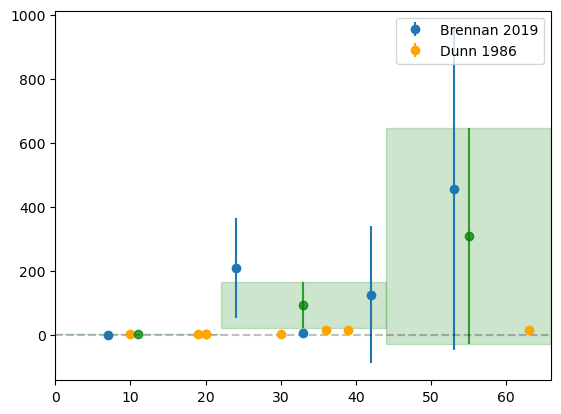

In [24]:
# Brennan 2019
num_sites = np.array([2,4,4,4,2])
stand_age_bren = np.array([7,24,33,42,53])
prefire_density = np.array([2205,48,3430,233,400])
prefire_density_se = np.array([35,14,308,136,240])
prefire_density_sd = prefire_density_se * np.sqrt(num_sites)
rec_density = np.array([0,10000,18500,29000,182000])
rec_density_se = np.array([0,2345,9385,18443,92000])
rec_density_sd = rec_density_se * np.sqrt(num_sites)
fecundity_bren = rec_density / prefire_density
fecundity_err_bren = np.zeros(len(fecundity_bren))
for i in range(len(fecundity_err_bren)):
    if (prefire_density[i] == 0) or (rec_density[i] == 0):
        fecundity_err = 0
    else:
        # fecundity_err = fecundity_bren[i] * np.sqrt((prefire_density_se[i]/prefire_density[i])**2 + (rec_density_se[i]/rec_density[i])**2)
        fecundity_err = fecundity_bren[i] * np.sqrt((prefire_density_sd[i]/prefire_density[i])**2 + (rec_density_sd[i]/rec_density[i])**2)
    fecundity_err_bren[i] = fecundity_err
plt.errorbar(stand_age_bren, fecundity_bren, yerr=fecundity_err_bren, fmt='o', label='Brennan 2019')

# Dunn 1986
stand_age_dunn = np.array([10,19,20,20,30,36,39,63])
fecundity_dunn = (np.array([0,0.1,2.9,26.5,15.7,1206.5,1387.3,1400]) / 100) + 1
# Assume something ad hoc for CV on Dunn's measurements
fecundity_err_dunn = np.repeat(0.75, len(fecundity_dunn)) * fecundity_dunn
# plt.scatter(stand_age_dunn, fecundity_dunn, color='orange', label='Dunn 1986')
plt.errorbar(stand_age_dunn, fecundity_dunn, yerr=fecundity_err_dunn, color='orange', label='Dunn 1986', fmt='o')

stand_age_all = np.concatenate((stand_age_bren, stand_age_dunn))
sort = np.argsort(stand_age_all)
stand_age_all = stand_age_all[sort]
fecundity_all = np.concatenate((fecundity_bren, fecundity_dunn))[sort]
fecundity_err_all = np.concatenate((fecundity_err_bren,fecundity_err_dunn))[sort]
weights = np.concatenate((num_sites, np.ones(len(stand_age_dunn))))[sort]
binwidth = 22
numbins = max(stand_age_all) // binwidth + (max(stand_age_all) % binwidth > 0)
age_cntrs = np.zeros(numbins)
mean_fecundities = []
bin_errors = []
for i in range(numbins):
    filt = ((stand_age_all > binwidth*i) & (stand_age_all <= binwidth*(i+1)))
    avg = np.average(fecundity_all[filt], weights=weights[filt])
    mean_fecundities.append(avg)
    age_cntr = binwidth*i + binwidth/2
    age_cntrs[i] = age_cntr
    err = (1/sum(weights[filt]))*np.sqrt(sum((fecundity_err_all[filt]*weights[filt])**2))
    bin_errors.append(err)
    # plt.fill_between([binwidth*i, binwidth*(i+1)], 0, avg, color='green', alpha=0.2)
    plt.fill_between([binwidth*i, binwidth*(i+1)], avg-err, avg+err, color='green', alpha=0.2)
plt.errorbar(age_cntrs, mean_fecundities, yerr=bin_errors, c='g', alpha=0.75, fmt='o')
plt.xlim(0,age_cntr+binwidth/2)

a_vec = np.arange(1,int(age_cntr+binwidth/2))
rho_max = avg
eta_rho = 0.3
a_mature = np.median(age_cntrs) + 3
rho_a = rho_max / (1+np.exp(-eta_rho*(a_vec-a_mature)))
# plt.plot(a_vec, rho_a, c='g')
plt.axhline(0,c='k',ls='--',alpha=0.25)
plt.legend()

In [25]:
def simulator(params):
    rho_max = params[0]; eta_rho = params[1]; a_mature = params[2]
    sigm_max = params[3]; eta_sigm = params[4]; a_sigm_star = a_mature
    
    # Read this in from file(s) in the actual script
    a_vec = np.concatenate((
                            np.repeat(stand_age_bren, num_sites), 
                            stand_age_dunn,
                            [numbins*binwidth + 1, (numbins+1)*binwidth]
                           ))
    a_vec.sort()
    
    rho_a = rho_max / (1+np.exp(-eta_rho*(a_vec-a_mature)))
    rng = np.random.default_rng()
    sigm_a = sigm_max / (1+np.exp(-eta_sigm*(a_vec-a_sigm_star)))
    epsilon_rho = rng.lognormal(np.zeros_like(a_vec), sigm_a)
    fecundities = rng.poisson(rho_a*epsilon_rho)
    
    mean_fecundities = np.zeros(numbins)
    bin_stdevs = np.zeros(numbins)
    results = np.empty(numbins*2 + 1)
    for i in range(numbins):
        filt = ((a_vec > binwidth*i) & (a_vec <= binwidth*(i+1)))
        fecundities_bin = fecundities[filt]
        mean_fecundities[i] = fecundities_bin.mean()
        bin_stdevs[i] = np.std(fecundities_bin, ddof=1)
    results[0:numbins] = mean_fecundities
    results[numbins:numbins*2] = bin_stdevs
    
    # Fecundity should level out by end of last bin
    # check using mean epsilon value
    mean_diff = rho_a[-1]*np.exp(sigm_a[-1]**2 / 2) - rho_a[-2]*np.exp(sigm_a[-2]**2 / 2) 
    results[-1] = mean_diff
    return results

In [26]:
# params = (rho_max, eta_rho, a_mature, 10.2, 0.2, 40)
# test = simulator(defaults); test

In [27]:
# defaults = [377, 0.08, 57, 1.5, 0.05, 57]
# defaults = [332, 0.11, 50.5, 1.5, 0.05, 65.5]
# defaults = [204, 0.15, 40, 1.06, 0.1, 30.5]
defaults = [220, 0.22, 36.5, 1.1, 0.4, 46] ###
# defaults = [220, 0.1, 45, 1.02, 0.4, 31.5]
# defaults = np.array([3.5552e+02, 1.2866e-01, 6.6720e+01, 2.1127e+00, 4.1359e-01, 5.5047e+01])
# with open("model_fitting/fecundity/posterior.pkl", "rb") as handle:
#     posterior = pickle.load(handle)
# defaults = posterior.map(force_update=True)
# defaults = [237.3416,   0.2681,  59.8591,   2.1659,   0.2490,  43.9686]
# defaults = [2.5166e+02, 4.4630e-01, 3.9959e+01, 1.0062e-02, 4.0116e-01, 4.6136e+01]
# defaults = [3.5603e+02, 2.1890e-01, 4.8983e+01, 5.5529e-01, 4.2548e-01, 6.7804e+01]
# defaults = [3.2345e+02, 1.2274e-01, 6.7662e+01, 1.6043e+00, 3.7612e-01, 4.9780e+01]
# defaults = [180.5287,   0.4360,  32.6226,   2.4970,   0.4183,  54.3859]
# defaults = [197.6786,   0.4087,  33.5344,   1.9475,   0.5985,  47.4960]
# defaults = [160.0945,   0.4382,  32.3579,   1.6829,   0.6191,  49.4165]
defaults = [3.0268e+02, 2.5887e-01, 3.7719e+01, 8.5499e-01, 5.2403e-01]
def plt_sim(rho_max=defaults[0], eta_rho=defaults[1], a_mature=defaults[2], 
            sigm_max = defaults[3], eta_sigm = defaults[4], a_sigm_star=defaults[2]):
    params = (rho_max, eta_rho, a_mature, sigm_max, eta_sigm)
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig, (ax1) = plt.subplots(1, 1, figsize=(7,6))
    ax1.axhline(0, ls='--', color='k')
    ax1.errorbar(age_cntrs, mean_fecundities, yerr=bin_errors, fmt='o', c='k')
    reps = 100
    all_res = np.zeros((reps, numbins*2 + 1))
    for rep in range(reps):
        res = simulator(params)
        all_res[rep] = res
    res = np.mean(all_res, axis=0)
    ax1.scatter(np.repeat(age_cntrs[0], reps), all_res[:,0], alpha=0.2, c='magenta')
    ax1.scatter(np.repeat(age_cntrs[1], reps), all_res[:,1], alpha=0.2, c='magenta')
    ax1.scatter(np.repeat(age_cntrs[2], reps), all_res[:,2], alpha=0.2, c='magenta')
    ax1.scatter(age_cntrs, res[0:numbins], c='cyan', alpha=0.75, marker='x', s=60, zorder=7)
    for i in range(0,numbins):
        ax1.fill_between([binwidth*i, binwidth*(i+1)], res[i]-res[i+numbins], res[i]+res[i+numbins], color='magenta', alpha=0.2)
    a_vec = np.arange(150)
    rho_a = rho_max / (1+np.exp(-eta_rho*(a_vec-a_mature)))
    ax1.plot(a_vec, rho_a, c='g')
    # ax1.set_ylim(-5,800)
    # ax1.set_ylim(-5,100)
    ax1.set_xlim(-1,120)
    sigm_a = sigm_max / (1+np.exp(-eta_sigm*(a_vec-a_sigm_star)))
    ax1_secy = ax1.twinx()
    ax1_secy.plot(a_vec, sigm_a, c='r')
    ax1_secy.set_ylim(-0.1,3)
    # ax2.plot(a_vec, rho_a, c='g')
    # ax2.set_ylim(-5,500)
interact(plt_sim, 
         rho_max=(10,600,1), eta_rho=(0.01,0.8,0.01), a_mature=(15,80,0.5), 
         sigm_max=(0.01,5,0.01), eta_sigm=(0.01,0.8,0.01))

interactive(children=(IntSlider(value=302, description='rho_max', max=600, min=10), FloatSlider(value=0.25887,…

<function __main__.plt_sim(rho_max=302.68, eta_rho=0.25887, a_mature=37.719, sigm_max=0.85499, eta_sigm=0.52403, a_sigm_star=37.719)>

#### Environmental stochasticity

In [10]:
defaults = [3.0268e+02, 2.5887e-01, 3.7719e+01, 8.5499e-01, 5.2403e-01]
rho_max=defaults[0]; eta_rho=defaults[1]; a_mature=defaults[2]; sigm_max = defaults[3]
eta_sigm = defaults[4]; a_sigm_star=defaults[2]
def lognorm_int(a):
    N = 10000
    sigm_a = sigm_max / (1+np.exp(-eta_sigm*(a-a_sigm_star)))
    logn_draws = np.random.lognormal(0, sigm_a, N)
    plt.hist(logn_draws, bins=50);
interact(lognorm_int, a = widgets.FloatSlider(value=0, min=0, max=100, step=1))

interactive(children=(FloatSlider(value=0.0, description='a', step=1.0), Output()), _dom_classes=('widget-inte…

<function __main__.lognorm_int(a)>

## Mortality

#### Starting from old model

Convert survival to mortality (just 1 minus survival) and find a reasonably well fitting function. Looks like a simple exponential won't do the job.

[0.07916696 0.15686624 0.02695244]


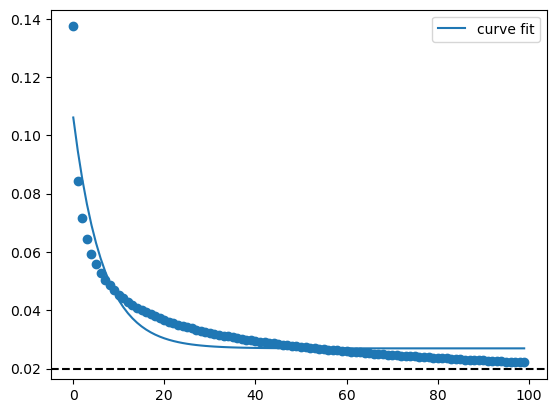

In [3]:
x = np.arange(100)
a = 17; b = 0.675
Sx = np.exp((x/a)**b - ((x+1)/a)**b)
plt.scatter(x,1-Sx)

p0 = [0.09, 0.1, 0.02]
popt, pcov = curve_fit(scaled_exp, x, 1-Sx, p0=p0)
plt.plot(x, scaled_exp(x, *popt), label='curve fit')
print(popt)

# plt.plot(x, scaled_exp(x, a=0.09, b=0.1, c=0.02), label='guess')
plt.legend()
plt.axhline(0.02, ls='--', c='k')

#### The new data
To converted recorded counts $\Bigl[\frac{\#}{\text{plot}}\Bigr]$ to density in $\Bigl[\frac{\#}{\text{ha}}\Bigr]$, do $\Bigl[\frac{\#}{\text{plot}}\Bigr] * \Bigl(\frac{100\text{m}^2}{\text{plot}}\Bigr)^{-1} * \Bigl(\frac{1\text{ha}}{10000\text{m}^2}\Bigr)^{-1}=\Bigl[\frac{\#}{\text{plot}}\Bigr]*100$

In [3]:
df = pd.read_excel('AACypress_Full.xlsx')
df_sub = df[df['SPECIESCODE'] == 'Cupfor']
tstar_vec = np.array([1,2,5])
unitid_vec = np.unique(np.array(df['UNITID']))
plot_vec = np.unique(np.array(df['PLOT']))
dummy = np.array([np.nan for tstar in tstar_vec])
# Create separate density vectors for seedlings and saplings
shape = (len(unitid_vec), len(plot_vec), len(tstar_vec))
seedlings = np.array(np.broadcast_to(dummy, shape))
saplings = np.array(np.broadcast_to(dummy, shape))

fire_year = 2003
density_scale = 1e3
min_density = 6*density_scale

for unitid_i, unitid in enumerate(unitid_vec):
    for plot in plot_vec:
        for tstar_i, tstar in enumerate(tstar_vec):
            year = fire_year + tstar
            counts = df_sub[(df_sub['YEAR'] == year) & (df_sub['PLOT'] == plot) & (df_sub['UNITID'] == unitid) & (df_sub['GROWTHFORM'] == 'Seedling')]['TOTALIN'].sum()
            seedlings[unitid_i][plot-1][tstar_i] = counts * density_scale
            counts = df_sub[(df_sub['YEAR'] == year) & (df_sub['PLOT'] == plot) & (df_sub['UNITID'] == unitid) & (df_sub['GROWTHFORM'] == 'Resprout')]['TOTALIN'].sum()
            saplings[unitid_i][plot-1][tstar_i] = counts * density_scale

total_density = seedlings + saplings

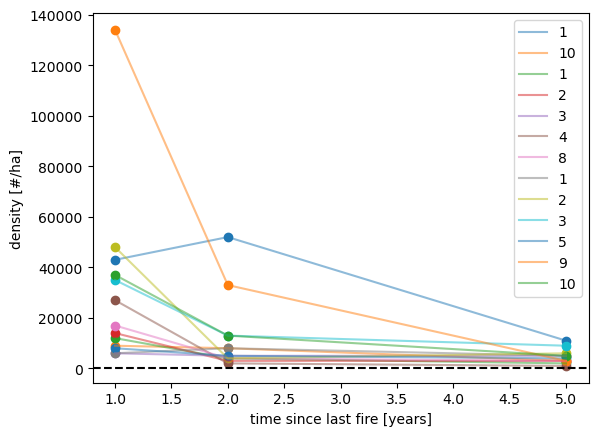

In [4]:
def densities_int(unitid_i):
    density_vec = total_density[int(unitid_i)]
    x = tstar_vec
    for plot in plot_vec:
        y = density_vec[plot-1]
        plt.scatter(x,y)
        plt.plot(x,y,alpha=0.5,label=plot)
    plt.legend()
    plt.ylabel('density [#/ha]')
    plt.xlabel('time since last fire [years]')
    plt.axhline(0, ls='--', color='k')
# interact(densities_int, unitid_i = widgets.FloatSlider(value=0, min=0, max=4, step=1))
# plt.show()

for unitid_i in range(len(unitid_vec)):
    x = tstar_vec
    for plot in plot_vec:
        y = total_density[unitid_i][plot-1]
        if y[0] < min_density:
            continue
        plt.scatter(x,y)
        plt.plot(x,y,alpha=0.5,label=plot)
    plt.legend()
    plt.ylabel('density [#/ha]')
    plt.xlabel('time since last fire [years]')
plt.axhline(0, ls='--', color='k')
plt.show()

In [5]:
num_pops = len(unitid_vec) * len(plot_vec)
total_density = total_density.reshape((num_pops,3))
min_density_filter = np.nonzero(total_density[:,0] < min_density)
total_density = np.delete(total_density, min_density_filter, axis=0)
# Also filter seedlings and saplings
seedlings = seedlings.reshape((num_pops,3))
seedlings = np.delete(seedlings, min_density_filter, axis=0)
saplings = saplings.reshape((num_pops,3))
saplings = np.delete(saplings, min_density_filter, axis=0)

In [6]:
mortality_vec = np.empty((total_density.shape[0], len(tstar_vec)-1))
mortality_vec[:] = np.nan
for m_i, plot_density in enumerate(total_density):
    for tstar_i, tstar in enumerate(tstar_vec[:-1]):
        # Calculate density change relative to initial
        delta_t = tstar_vec[tstar_i+1] - tstar
        delta_density = plot_density[tstar_i+1] - plot_density[tstar_i]
        prop_density_change = delta_density / plot_density[tstar_i]
        mortality = (-1 * prop_density_change) / delta_t
        mortality_vec[m_i][tstar_i] = mortality

In [7]:
color = plt.cm.tab20(np.linspace(0, 1, mortality_vec.shape[0]))
def scaled_exp_intplt(a,b,c):
    for plot_i, plot_mortality in enumerate(mortality_vec):
        plt.plot([1,2], plot_mortality[0].repeat(2), color=color[plot_i])
        plt.plot([2,5], plot_mortality[1].repeat(2), color=color[plot_i])
        plt.plot([1.95,2.05], plot_mortality, color=color[plot_i])
    # mean_mortality_vec = np.mean(mortality_vec, axis=0)
    x = np.arange(0,10)
    # plt.scatter(x,mean_mortality_vec, color='black')
    # plt.plot(x,mean_mortality_vec, ls='--', color='black')
    plt.plot(x, scaled_exp(x,a,b,c), color='red')
    plt.scatter(x, scaled_exp(x,a,b,c), color='red', s=10)
    
    plt.ylabel('mortality rate')
    plt.xlabel('time since last fire [years]')
    plt.axhline(0,ls='-',alpha=0.45,zorder=-1, color='black')
interact(scaled_exp_intplt, a = widgets.FloatSlider(value=0.98, min=0.01, max=10, step=0.01),
         b = widgets.FloatSlider(value=0.77, min=0.001, max=1.5, step=0.001),
         c = widgets.FloatSlider(value=0.04, min=0.01, max=0.1, step=0.01))

interactive(children=(FloatSlider(value=0.98, description='a', max=10.0, min=0.01, step=0.01), FloatSlider(val…

<function __main__.scaled_exp_intplt(a, b, c)>

#### Environmental stochasticity

In [55]:
def lognorm_int(N=10000, t=0):
    mu=0; sigma=1.1527; tau=0.01
    # N = 10000
    sigma_t = sigma*np.exp(-tau*t)
    logn_draws = np.random.lognormal(mu,sigma_t,N)
    plt.hist(logn_draws, bins=50);
    mean = np.exp(mu + sigma_t**2/2)
    plt.axvline(mean, ls='--', c='k', label=str(mean))
    eff_mean = np.mean(logn_draws)
    plt.axvline(eff_mean, ls='--', c='r', label=str(eff_mean))
    plt.legend()
interact(lognorm_int, 
         t = widgets.FloatSlider(value=1, min=0, max=40, step=0.5), 
         N = widgets.IntSlider(value=10000, min=50, max=50000, step=10))

interactive(children=(IntSlider(value=10000, description='N', max=50000, min=50, step=10), FloatSlider(value=1…

<function __main__.lognorm_int(N=10000, t=0)>

In [11]:
def lognorm_int(mu, sigma, tau, t):
    N = 10000
    logn_draws = np.random.lognormal(mu,sigma*np.exp(-tau*t),N)
    plt.hist(logn_draws, bins=50);
interact(lognorm_int,
        mu = widgets.FloatSlider(value=0., min=-5.0, max=5, step=0.01),
        sigma = widgets.FloatSlider(value=0.75, min=0.0, max=2, step=0.05),
        tau = widgets.FloatSlider(value=0.01, min=0.01, max=0.5, step=0.01),
        t = widgets.FloatSlider(value=0, min=0, max=100, step=1))

interactive(children=(FloatSlider(value=0.0, description='mu', max=5.0, min=-5.0, step=0.01), FloatSlider(valu…

<function __main__.lognorm_int(mu, sigma, tau, t)>

#### Suss out non-fire year reproduction rates
Think we want small initial baseline rates with high initial environmental stochasticity, both of which decay quickly.

In [14]:
r_1 = seedlings[:,1] / total_density[:,0]; r_1

array([0.04651163, 0.88888889, 0.        , 0.        , 0.        ,
       0.05882353, 0.        , 0.        , 0.125     , 0.        ,
       0.        ])

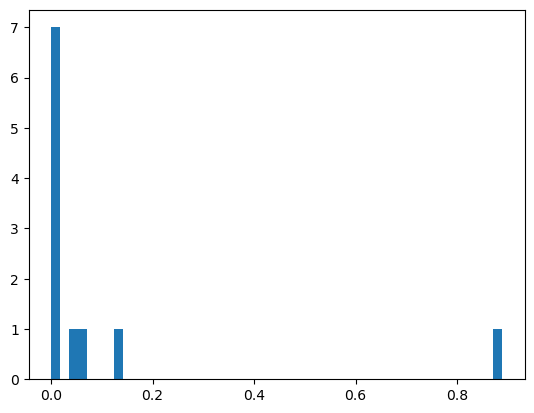

In [19]:
plt.hist(r_1, bins=50);

In [5]:
def nonfire_repro(beta_r, sigma_r, tau_r, tstar):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    x = np.arange(0,15)
    y = np.exp(-beta_r * x)
    ax1.scatter(x,y)
    ax1.plot(x,y)
    ax1.set_ylim(-0.05,1.05)
    ax1.set_title(r'$r_{t^*}$')
    # ax1.show()
    
    # Now plot histogram of env stoch distribution
    N = 1000
    # logn_draws = np.random.lognormal(0.0,g-h*t,N)
    logn_draws = np.random.lognormal(0.0,sigma_r*np.exp(-tau_r*tstar),N)
    ax2.hist(logn_draws, bins=50);
    ax2.set_title(r'$\epsilon_r$')
    
interact(nonfire_repro, beta_r = widgets.FloatSlider(value=1, min=0.01, max=2, step=0.01),
        sigma_r = widgets.FloatSlider(value=1.4, min=0.0, max=2, step=0.05),
        tau_r = widgets.FloatSlider(value=0.2, min=0.001, max=1, step=0.0001),
        tstar = widgets.FloatSlider(value=1, min=0, max=50, step=1))

interactive(children=(FloatSlider(value=1.0, description='beta_r', max=2.0, min=0.01, step=0.01), FloatSlider(…

<function __main__.nonfire_repro(beta_r, sigma_r, tau_r, tstar)>

In [6]:
def lognorm(mu, sigma):
    N = 1000
    # logn_draws = np.random.lognormal(0.0,g-h*t,N)
    logn_draws = np.random.lognormal(mu,sigma,N)
    plt.hist(logn_draws, bins=50);
    plt.axvline(logn_draws.mean(), color='red')
    
interact(lognorm, mu = widgets.FloatSlider(value=0, min=-1, max=1, step=0.01),
               sigma = widgets.FloatSlider(value=0.01, min=0.01, max=2.5, step=0.01))


interactive(children=(FloatSlider(value=0.0, description='mu', max=1.0, min=-1.0, step=0.01), FloatSlider(valu…

<function __main__.lognorm(mu, sigma)>

### Density dependence

#### Playing with functional form

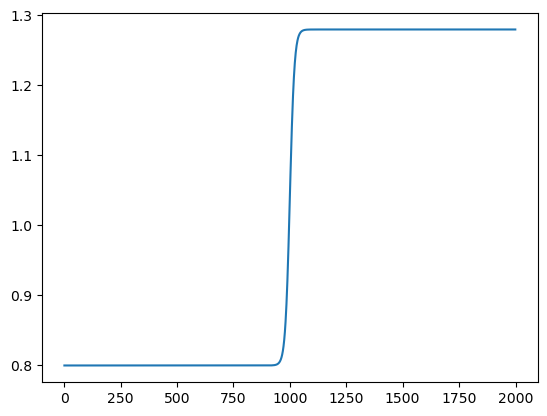

In [42]:
'''Sketching out what the final mortality rates look like when m_min=0.1 and 
   m_max=m_min*d(t_star)=m_min*1.6'''
N = np.arange(1,2000,1); N
m_min_t = 0.8
m_max_t = m_min_t * 0.6
r = 0.1
K_t = 1000
m = m_min_t + m_max_t / (1+np.exp(-r*(N-K_t)))
plt.plot(N,m)

In [31]:
# Assumptions from Regan 2012
d_t = np.array([1.6,1.5,1.4,1.3,1.2,1.1,1.1])
d_t = d_t - 1
t = np.array([1,2,4,6,8,18,100])
x = np.arange(1,100)

def scaled_exp_intplt(a,b,c):
    plt.scatter(t,d_t)
    popt, pcov = curve_fit(scaled_exp, t, d_t)
    plt.plot(x, scaled_exp(x, *popt)); popt
    # plt.scatter(x, scaled_exp(x,a,b,c), color='red', s=10)
    plt.plot(x, scaled_exp(x,a,b,c), color='red')
    plt.ylabel('pct inc in mortality with dens dep')
    plt.xlabel('age')
interact(scaled_exp_intplt, a = widgets.FloatSlider(value=0.6185, min=0.01, max=3.5, step=0.01),
         b = widgets.FloatSlider(value=0.189, min=0.01, max=1.5, step=0.01),
         c = widgets.FloatSlider(value=0.088, min=0.01, max=0.5, step=0.01))

interactive(children=(FloatSlider(value=0.6185, description='a', max=3.5, min=0.01, step=0.01), FloatSlider(va…

<function __main__.scaled_exp_intplt(a, b, c)>

#### Looking at the data
Run mortality cells first

Data on both seedling K looks reasonably close to Mark-Nich. Seems like K will be at a much lower value for "adults" than previous model, though, given the data at age 14.

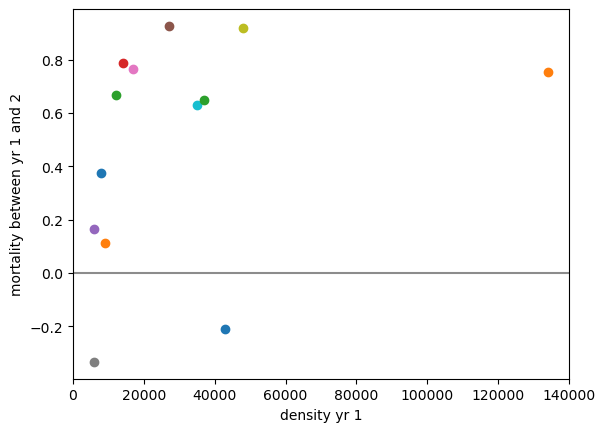

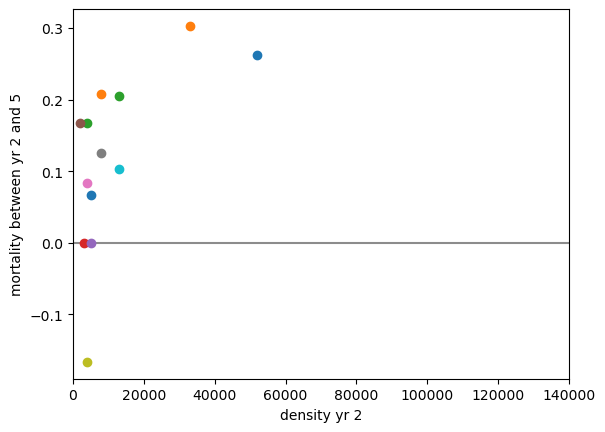

In [30]:
correct = False
for mort_i in range(mortality_vec.shape[1]):
    for density, mortality, seed_density in zip(total_density, mortality_vec, seedlings):
        if (tstar_vec[mort_i+1] == 2) and correct:
            corrected_density = density[mort_i+1] - seed_density[mort_i+1]
            # print(density[0], seed_density[mort_i+1], density[mort_i+1], corrected_density)
            corrected_mortality = -1*(corrected_density - density[0]) / density[0]
            plt.scatter(density[0], corrected_mortality)
        else:
            plt.scatter(density[mort_i], mortality[mort_i])
    plt.axhline(0,ls='-',alpha=0.45,zorder=-1, color='black')
    plt.ylabel('mortality between yr {} and {}'.format(tstar_vec[mort_i], tstar_vec[mort_i+1]))
    plt.xlabel('density yr {}'.format(tstar_vec[mort_i]))
    plt.xlim(0,140*density_scale)
    plt.show()

In [32]:
K1 = 60 * density_scale
K2 = 32 * density_scale
K_adult = 10.24 * density_scale
def scaled_exp_intplt(K_seedling, kappa, K_adult):
    plt.scatter([1,2], np.array([K1, K2]), c='k')
    plt.axhline(K_adult, c='k', ls='--')
    x = np.arange(40)
    plt.plot(x, scaled_exp(x,K_seedling, kappa, K_adult), color='b')
    plt.scatter(x, scaled_exp(x,K_seedling, kappa, K_adult), color='b', s=10)
    plt.ylabel('carrying capacity')
    plt.xlabel('age [years]')

defaults = [100*density_scale, 0.7, 10*density_scale]
interact(scaled_exp_intplt, K_seedling = widgets.FloatSlider(value=defaults[0], min=0.01*K1, max=250*density_scale, step=10),
         kappa = widgets.FloatSlider(value=defaults[1], min=0.01, max=0.9, step=0.01),
         K_adult = widgets.FloatSlider(value=defaults[2], min=2.5*density_scale, max=17*density_scale, step=10))

interactive(children=(FloatSlider(value=100000.0, description='K_seedling', max=250000.0, min=600.0, step=10.0…

<function __main__.scaled_exp_intplt(K_seedling, kappa, K_adult)>